<a href="https://colab.research.google.com/github/gbend22/ml-homework-4/blob/main/loading_kaggle_data_to_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip /content/drive/MyDrive/Assignment4/train.csv.zip

Archive:  /content/drive/MyDrive/Assignment4/train.csv.zip
  inflating: train.csv               


In [4]:
! unzip /content/drive/MyDrive/Assignment4/test.csv.zip

Archive:  /content/drive/MyDrive/Assignment4/test.csv.zip
  inflating: test.csv                


Device available:  cuda


In [39]:

df = pd.read_csv('/content/train.csv')

def process_pixels(pixel_str):
    pixels = np.fromstring(pixel_str, sep=' ', dtype=np.uint8)
    return pixels.reshape(48, 48)

images = np.array([process_pixels(p) for p in df['pixels']])
labels = df['emotion'].values

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (28709, 48, 48)
Labels shape: (28709,)


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=7, stratify=labels)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=7, stratify=y_temp)

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts (H x W) numpy array → (1 x H x W) torch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale: mean=0.5, std=0.5
])

In [42]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image.astype(np.uint8), mode='L')
        if self.transform:
            image = self.transform(image)
        return image, label

In [43]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=transform)

In [69]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [45]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

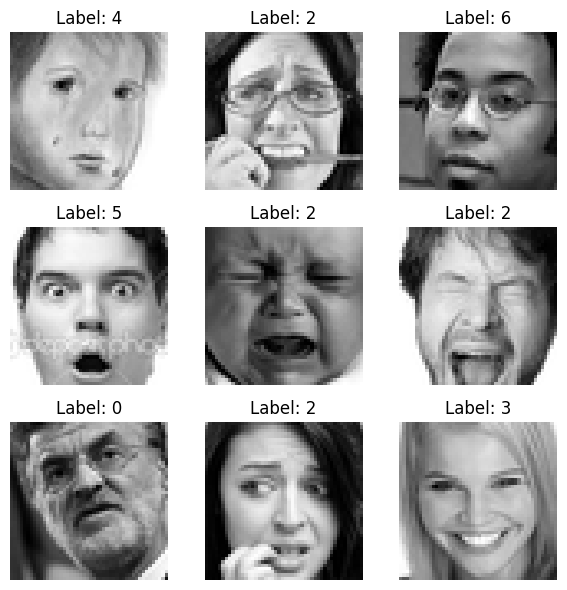

In [46]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols, figsize=(6, 6))

for row in range(n_rows):
    for col in range(n_cols):
        idx = np.random.randint(len(X_train))
        image = X_train[idx]
        label = y_train[idx]

        axarr[row, col].imshow(image, cmap='gray')
        axarr[row, col].set_title(f"Label: {label}")
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [70]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 6 * 6, 128)
        self.output = nn.Linear(128, 7)

    def forward(self, x):
        x = self.relu(self.pooling(self.conv1(x)))
        x = self.relu(self.pooling(self.conv2(x)))
        x = self.relu(self.pooling(self.conv3(x)))
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x
model = Net().to(device)
model = model.to(device)

In [71]:
from torchsummary import summary
summary(model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
         MaxPool2d-2           [-1, 32, 24, 24]               0
              ReLU-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          18,496
         MaxPool2d-5           [-1, 64, 12, 12]               0
              ReLU-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
         MaxPool2d-8            [-1, 128, 6, 6]               0
              ReLU-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                  [-1, 128]         589,952
           Linear-12                    [-1, 7]             903
Total params: 683,527
Trainable params: 683,527
Non-trainable params: 0
-------------------------------

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [57]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        optimizer.step()

        train_acc = (outputs.argmax(1) == labels).sum().item()
        total_acc_train += train_acc

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (outputs.argmax(1) == labels).sum().item()
            total_acc_val += val_acc

    train_size = len(train_dataset)
    val_size = len(val_dataset)

    total_loss_train_plot.append(round(total_loss_train / len(train_loader), 4))
    total_loss_validation_plot.append(round(total_loss_val / len(val_loader), 4))
    total_acc_train_plot.append(round(total_acc_train / train_size * 100, 2))
    total_acc_validation_plot.append(round(total_acc_val / val_size * 100, 2))

    print(f'''Epoch {epoch+1}/{EPOCHS}
    Train Loss: {round(total_loss_train / len(train_loader), 4)} | Train Accuracy: {round(total_acc_train / train_size * 100, 2)}%
    Val Loss: {round(total_loss_val / len(val_loader), 4)} | Val Accuracy: {round(total_acc_val / val_size * 100, 2)}%''')
    print("="*30)


Epoch 1/10 
    Train Loss: 1.6689 | Train Accuracy: 33.78% 
    Val Loss: 1.548 | Val Accuracy: 39.64%
Epoch 2/10 
    Train Loss: 1.4796 | Train Accuracy: 43.64% 
    Val Loss: 1.4689 | Val Accuracy: 43.57%


KeyboardInterrupt: 

In [19]:
with torch.no_grad():
    model.eval()
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        predictions = model(inputs)

        acc = (predictions.argmax(1) == labels).sum().item()
        total_acc_test += acc

        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

test_size = len(test_dataset)
average_loss = round(total_loss_test / len(test_loader), 4)
accuracy = round((total_acc_test / test_size) * 100, 2)

print(f"Test Accuracy: {accuracy}%")
print(f"Test Loss: {average_loss}")


Test Accuracy: 53.24%
Test Loss: 1.2511


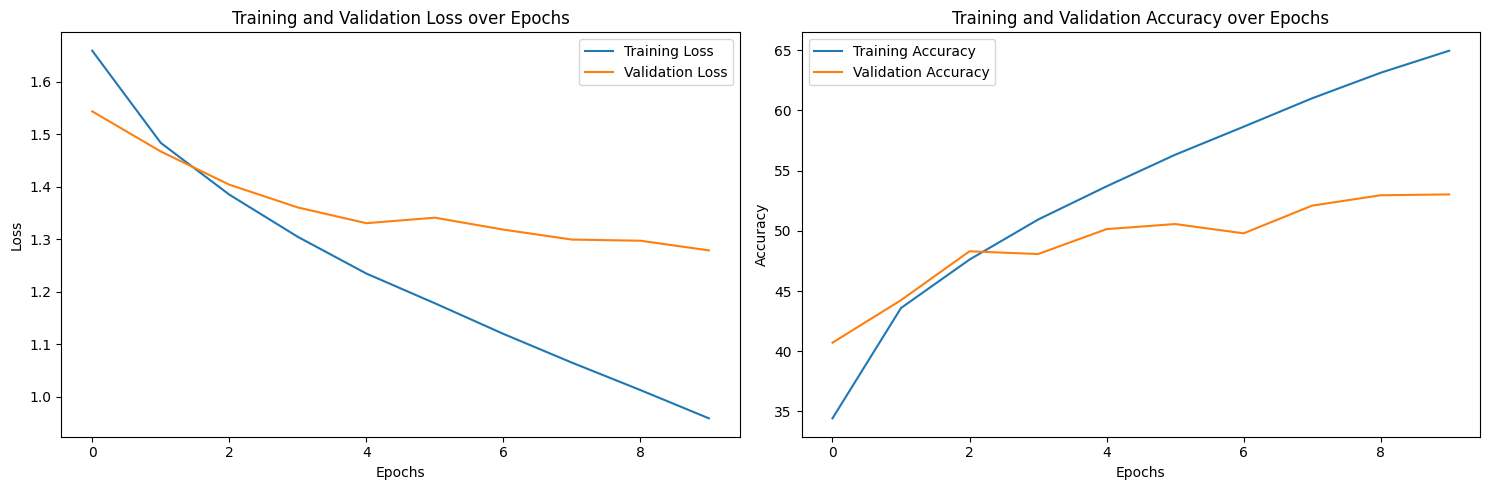

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [28]:
!pip install wandb
import wandb

In [32]:
!wandb login

wandb: Currently logged in as: gbend22 (gbend22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [73]:
wandb.init(
    project="ml-homework-4",
    group="normal-cnn",
    name="base",
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "architecture": "CustomCNN"
    }
)


for epoch in range(EPOCHS):
    model.train()
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        total_acc_train += (outputs.argmax(1) == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            total_acc_val += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_acc_train / len(train_dataset)
    val_acc = total_acc_val / len(val_dataset)
    train_loss = total_loss_train / len(train_loader)
    val_loss = total_loss_val / len(val_loader)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc
    })

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

torch.save(model.state_dict(), "model.pth")
wandb.save("model.pth")
wandb.finish()

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
train_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
val_accuracy,▁▄▅▅▇▇▇██▇▇▇▇▇▇▇▇▇
val_loss,▅▄▃▂▂▁▁▁▁▂▂▃▃▄▅▆██
epoch,18
train_accuracy,0.82444
train_loss,0.50607
val_accuracy,0.51997
val_loss,1.68506


Epoch 1: Train Loss = 1.6568, Val Loss = 1.5379, Train Acc = 0.3470, Val Acc = 0.4092
Epoch 2: Train Loss = 1.4638, Val Loss = 1.4367, Train Acc = 0.4444, Val Acc = 0.4515
Epoch 3: Train Loss = 1.3552, Val Loss = 1.3785, Train Acc = 0.4895, Val Acc = 0.4693
Epoch 4: Train Loss = 1.2741, Val Loss = 1.3397, Train Acc = 0.5223, Val Acc = 0.4958
Epoch 5: Train Loss = 1.2085, Val Loss = 1.3237, Train Acc = 0.5500, Val Acc = 0.5158
Epoch 6: Train Loss = 1.1477, Val Loss = 1.2973, Train Acc = 0.5754, Val Acc = 0.5190
Epoch 7: Train Loss = 1.0916, Val Loss = 1.2750, Train Acc = 0.5996, Val Acc = 0.5267
Epoch 8: Train Loss = 1.0332, Val Loss = 1.3020, Train Acc = 0.6233, Val Acc = 0.5283
Epoch 9: Train Loss = 0.9793, Val Loss = 1.2862, Train Acc = 0.6409, Val Acc = 0.5346
Epoch 10: Train Loss = 0.9232, Val Loss = 1.3261, Train Acc = 0.6638, Val Acc = 0.5237


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▃▄▆▇▇███▇
val_loss,█▅▄▃▂▂▁▂▁▂
epoch,10
train_accuracy,0.66376
train_loss,0.9232
val_accuracy,0.52369
val_loss,1.32609
